<a href="https://colab.research.google.com/github/timwinter06/internship/blob/master/cnn_lstm_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras import utils
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM

import scipy.io as sio
import os
import random

from itertools import product
from collections import namedtuple

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Define functions

def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    return a, b

def feature_normalize(dataset, label):
    
    mu = np.mean(dataset, axis=1)
    sigma = np.std(dataset, axis=1)
    
    if np.any(sigma == 0):
        print('There are sigmas = 0, these are removed.')
        
    # Find where sigmas are zero and remove those trials
    ind = np.where(sigma == 0)
    dataset = np.delete(dataset,ind,0)
    label = np.delete(label,ind,0)
    sigma = np.delete(sigma,ind,0)
    mu = np.delete(mu,ind,0)
    normal = np.transpose((np.transpose(dataset) - mu)/sigma)
    
    return normal, label, ind

def import_data(animal, direct): # select animal (as string) to import data from
    # Import all the data in the Processed data file
    directory = direct + animal
    fnames = os.listdir(directory)
    whisk_data = {}
    nr_files = len(fnames)
    for i in range (0, nr_files):
        fname = directory + '//' + fnames[i]
        whisk_data[i] = sio.loadmat(fname)
    return (whisk_data)

def pre_process(whisk_data, no_zero, corr):
    nr_files = len(whisk_data.keys())
    shapes = np.zeros((2,nr_files))
    for i in range (0,nr_files):
        shapes[:,i] = whisk_data[i]['xtrain'].shape
    # Pad the whisking traces to ensure they are all the same length
    length = int(np.min(shapes[1,:]))
    whisk = {}  
    for i in range (0,nr_files):
        whisk_2 = np.zeros((whisk_data[i]['xtrain'].shape[0], length))
        whisk_2[:,0:int(length/2)] = whisk_data[i]['xtrain'][:,0:int(length/2)]
        whisk_2[:,int(length/2)+1:] = whisk_data[i]['xtrain'][:,whisk_data[i]['xtrain'].shape[1]-int(length/2)+1:]
        whisk[i] = whisk_2
    
    # Let's create one array with all of the training data 
    x_whisk = whisk[0]
    y_whisk = whisk_data[0]['ytrain']

    for i in range (1,nr_files):
        x_whisk = np.concatenate((x_whisk , whisk[i]), axis =0)
        y_whisk = np.concatenate((y_whisk , whisk_data[i]['ytrain']), axis =0)
        
    correct = whisk_data[0]['correct']
    for i in range (1,nr_files):
        correct = np.concatenate((correct,whisk_data[i]['correct']),axis = 0)
            
    if no_zero == 1:
        # Delete rows of array with no pole location (pole location = 0)
        zero = np.where(y_whisk[:,1] == 0)
        x_whisk = np.delete(x_whisk,zero,0)
        y_whisk = np.delete(y_whisk,zero,0)  
        correct = np.delete(correct,zero,0)
    if corr == 1:
        # Only take correct data
        ind = np.where(correct == 1)
        x_whisk = x_whisk[ind[0],:]
        y_whisk = y_whisk[ind[0],:]
        
    x_whisk, y_whisk = shuffle_in_unison(x_whisk, y_whisk)
    # Split data into train and test data, roughly 80-20
    split = round(0.8*x_whisk.shape[0])
    xtrain = x_whisk[0:split,:]
    xtest = x_whisk[split + 1:,:]
    ytrain = y_whisk[0:split,0]
    ytest = y_whisk[split + 1:,0]
    xtrain = xtrain.astype("float32")
    ytrain = ytrain.astype("float32")
    xtest = xtest.astype("float32")
    ytest = ytest.astype("float32")
    length_2_trial = xtrain.shape[1]
    length_trial = int(length_2_trial/2)
    x_train_angle = xtrain[:, length_trial:length_2_trial ]
    x_train_curve = xtrain[:, 0:length_trial ]
    x_test_angle = xtest[:, length_trial:length_2_trial ]
    x_test_curve = xtest[:, 0:length_trial ]
    # And normalise the data
    x_train_curve, ytrain, ind_1 = feature_normalize(x_train_curve, ytrain)
    x_train_angle = np.delete(x_train_angle,ind_1[0],0)
    x_train_angle, ytrain, ind_2 = feature_normalize(x_train_angle, ytrain)
    x_train_curve = np.delete(x_train_curve,ind_2[0],0)
    x_test_curve, ytest, ind_3 = feature_normalize(x_test_curve, ytest)
    x_test_angle = np.delete(x_test_angle,ind_3[0],0)
    x_test_angle, ytest, ind_4 = feature_normalize(x_test_angle, ytest)
    x_test_curve = np.delete(x_test_curve,ind_4[0],0)
    # concatenate all data
    x_train_all = np.concatenate((x_train_curve, x_train_angle), axis = 1)
    x_test_all = np.concatenate((x_test_curve, x_test_curve), axis = 1)
    for i in range (0,ytrain.shape[0]):
        if ytrain[i] == -1:
            ytrain[i] = 0
    for i in range (0,ytest.shape[0]):
        if ytest[i] == -1:
            ytest[i] = 0
    num_classes = 2
    ytrain = utils.to_categorical(ytrain, num_classes)
    ytest = utils.to_categorical(ytest, num_classes)
    return (x_train_all, x_test_all, ytrain, ytest, x_train_curve, x_train_angle, x_test_curve, x_test_angle)


def prediction(model, y_test, x_test, x_train_curve, x_train_angle, CNN):

  if CNN == 0:
    TIME_PERIODS = x_train_curve.shape[1]
    num_features = 2
    number_samples = x_train_curve.shape[0]

    # Create the correct input arrays for the LSTM network

    x_train = np.zeros((number_samples, TIME_PERIODS, num_features))

    x_train[:,:,0] = x_train_angle
    x_train[:,:,1] = x_train_curve
    x_test = x_train

  # Find out the predictions of the model
  y_pred_test = model.predict(x_test)

  if CNN == 1:
    y_pred_label = np.zeros((len(y_test),2))
  # Change to 1s and 0s
    for i in range (len(y_test)):
      if y_pred_test[i,0] > y_pred_test[i,1]:
        y_pred_label[i,:] = [1, 0]
      else:
        y_pred_label[i,:] = [0, 1]
  elif CNN == 0:
    y_pred_label = np.zeros((len(y_test),1))
    yte = np.zeros(len(y_test))
    for i in range (0,len(y_test)):
      if np.all(y_test[i,:] == [1, 0]):
        yte[i] = 1
    y_test = yte
    # Changes to 1s and 0s
    for i in range (len(y_test)):
      if y_pred_test[i] > 0.5:
        y_pred_label[i] = 1

  # Make empty list in which to store trial numbers which are misclassified and another for correctly classified trials
  y_incorrect = []
  y_correct = []

  # Loop over all trials to check if they are classifed correctly
  for i in range (len(y_test)):
    if CNN == 1:
      if np.all(y_pred_label[i,:] != y_test[i,:]):
      # Store the 'incorrect' trials
        y_incorrect = np.append(y_incorrect,i)
      else:
        y_correct = np.append(y_correct,i)
    elif CNN == 0:
      if y_pred_label[i] != y_test[i]:
        y_incorrect = np.append(y_incorrect,i)
      else:
        y_correct = np.append(y_correct, i)

  # Change float array to int array
  y_incorrect = y_incorrect.astype(int)
  y_correct = y_correct.astype(int)

  # Calculate accuracy
  acc = 1 - (len(y_incorrect)/len(y_test))

  return(acc, y_correct, y_incorrect, y_pred_test, y_pred_label)

def get_runs(params):
  Run = namedtuple('Run', params.keys())
  runs = []
  for v in product(*params.values()):
      runs.append(Run(*v))
  return runs

def plot_some(x_t_c, x_t_a, ytrain, number, save, name, rnd ):
    # Lets plot random proximal trials and 10 random distal trials
    prox = np.where(ytrain == [1, 0])
    dist = np.where(ytrain == [0, 1])
    width = 0.5
    mark = 0.5
    ymin = -20
    ymax = 20

    prox = np.ndarray.tolist(prox[0])
    dist = np.ndarray.tolist(dist[0])

    fig = plt.figure( figsize = (18,9))

    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)
    
    if rnd == 1:
      rnd_p = random.sample(prox, number)
      rnd_d = random.sample(dist, number)
    elif rnd == 0:
      rnd_p = prox
      rnd_d = dist
 
    x_train_curve = x_t_c
    x_train_angle = x_t_a

    for n in range (0, len(rnd_p)):
        # Plot proximal
        ax1.plot(x_train_curve[rnd_p[n],:],'b',linewidth = width, markersize = mark) # plot curve
        ax1.set_title('Proximal curvature')
        ax1.set_ylim([ymin,ymax])
        ax1.set_xlabel('time/ms')
        ax2.plot(x_train_angle[rnd_p[n],:],'b',linewidth = width,markersize = mark) # plot angle
        ax2.set_title('Proximal angle')
        ax2.set_ylim([ymin,ymax])
        ax2.set_xlabel('time/ms')
    for n in range (0, len(rnd_d)):
        # Plot distal
        ax3.plot(x_train_curve[rnd_d[n],:],'r',linewidth = width,markersize = mark) # plot curve
        ax3.set_title('Distal curvature')
        ax3.set_ylim([ymin,ymax])
        ax3.set_xlabel('time/ms')
        ax4.plot(x_train_angle[rnd_d[n],:],'r',linewidth = width,markersize = mark) # plot angle
        ax4.set_title('Distal angle')
        ax4.set_ylim([ymin,ymax])
        ax4.set_xlabel('time/ms')
    if save == 1:
      fig.savefig(name)
    return()


In [ ]:
# Import all the data and preprocess
whisk_data = import_data('an171923','/content/drive/My Drive/Processed data//')
# Choose if you want data with no pole location and if you want correct trials
no_zero , corr = 1 , 1
xtrain, xtest, ytrain, ytest, x_t_c, x_t_a, x_test_c, x_test_a = pre_process(whisk_data, no_zero, corr)
# Plot a number of the trials
#number = 100
#plot_some(x_t_c, x_t_a, ytrain, number)

# Create the correct input arrays for the LSTM network

TIME_PERIODS = x_t_c.shape[1]
num_features = 2
number_samples = x_t_c.shape[0]
number_test = x_test_c.shape[0]

x_train = np.zeros((number_samples, TIME_PERIODS, num_features))
x_test = np.zeros((number_test, TIME_PERIODS, num_features))

x_train[:,:,0] = x_t_a
x_train[:,:,1] = x_t_c
x_test[:,:,0] = x_test_a
x_test[:,:,1] = x_test_c

There are sigmas = 0, these are removed.


In [ ]:
class prediction_stats:

  def __init__(self, acc, y_correct, y_incorrect, y_pred_test, y_l):
    self.acc = acc
    self.y_correct = y_correct
    self.y_incorrect = y_incorrect
    self.y_pred_test = y_pred_test
    self.y_l = y_l

In [ ]:
# Get the incorrectly classified trials and the correctly classified trials
# Load the model 
model_lstm = load_model('/content/drive/My Drive/LSTM_CNN_0.86')
model_cnn = load_model('/content/drive/My Drive/CNN_3_layers_acc_0.78')

# Get the stats for the two models 
acc, y_correct, y_incorrect, y_pred_test, y_l = prediction(model_cnn, ytest, xtest, 1)
cnn_test = prediction_stats(acc, y_correct, y_incorrect, y_pred_test, y_l )
acc, y_correct, y_incorrect, y_pred_test, y_l = prediction(model_lstm, ytest, x_test, 0)
lstm_test = prediction_stats(acc, y_correct, y_incorrect, y_pred_test, y_l )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Get the stats for the two models 
acc, y_correct, y_incorrect, y_pred_test, y_l = prediction(model_cnn, ytrain, xtrain, 1)
cnn_train = prediction_stats(acc, y_correct, y_incorrect, y_pred_test, y_l )
acc, y_correct, y_incorrect, y_pred_test, y_l = prediction(model_lstm, ytrain, x_train, 0)
lstm_train = prediction_stats(acc, y_correct, y_incorrect, y_pred_test, y_l )

In [ ]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

In [ ]:
inter_train = intersection(cnn_train.y_incorrect, lstm_train.y_incorrect)
inter_test = intersection(cnn_test.y_incorrect, lstm_test.y_incorrect)

print(len(inter_train))
print(len(lstm_train.y_incorrect))
print(len(cnn_train.y_incorrect))

print(len(inter_test))
print(len(lstm_test.y_incorrect))
print(len(cnn_test.y_incorrect))

228
319
365
51
74
105


In [ ]:
def make_cnn(x, y, hyper):
  n = 0 
  TIME_PERIODS = int(x.shape[1]/2)
  input_shape = x.shape[1]
  num_sensors = 2
  num_classes = 2 
  EPOCHS = hyper[n].epochs

  # Add first layer
  model_m = Sequential()
  model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
  model_m.add(Conv1D(hyper[n].Filter_number, hyper[n].Filter_size_1, activation='relu', input_shape=(TIME_PERIODS,num_sensors)))
  # Add second layer    
  model_m.add(MaxPooling1D(hyper[n].Pooling_1))
  model_m.add(Conv1D(hyper[n].Filter_number, hyper[n].Filter_size_2, activation='relu'))
  # Add third layer
  model_m.add(MaxPooling1D(hyper[n].Pooling_2))
  model_m.add(Conv1D(hyper[n].Filter_number, hyper[n].Filter_size_3, activation='relu'))
  # Poolng, droput and output  
  model_m.add(GlobalAveragePooling1D())
  model_m.add(Dropout(0.5))
  model_m.add(Dense(num_classes, activation='softmax'))
  # End of CNN
  callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=1)]

  # Train CNN                                                     
  model_m.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    
  history = model_m.fit(x,y,
                        batch_size = hyper[n].Batch_size,
                        epochs=EPOCHS,
                        callbacks=callbacks_list,
                        validation_split=0.2,verbose=0)
  return( model_m, history)          

hyper = {'Batch_size': [32]
          ,'Filter_number': [ 200]        
          ,'Filter_size_1': [10]
          ,'Pooling_1': [3]
          ,'Filter_size_2': [ 10]
          ,'Pooling_2': [3]
          ,'Filter_size_3': [10]
          ,'epochs':[10]
          }
            

In [ ]:
def make_lstm(x_train_curve, x_train_angle, y, hyper):
  n = 0 
  # Change the y labels to 1D 1s or 0s.

  ytr = np.zeros(len(y))
  for i in range (0,len(y)):
    if np.all(y[i,:] == [1, 0]):
      ytr[i] = 1

  y = ytr
  TIME_PERIODS = x_train_curve.shape[1]
  num_features = 2
  number_samples = x_train_curve.shape[0]

  # Create the correct input arrays for the LSTM network

  x_train = np.zeros((number_samples, TIME_PERIODS, num_features))

  x_train[:,:,0] = x_train_angle
  x_train[:,:,1] = x_train_curve

  # First define the dictionaires which return the test accuracy and loss, 
  # train accuracy and loss, and validate accuracy and loss.
    
  all_score = {} 
  all_history = {}
    
  # Define some basic parameters
  num_sensors = 2
  num_classes = 2 

    # Build the LSTM 
  model_m = Sequential()
    # Build a first convolutional layer
  model_m.add(Conv1D(hyper[n].Filter_number, hyper[n].Filter_size_1, activation='relu', input_shape=(TIME_PERIODS,num_features)))
    # Add a second convolutional layer
  model_m.add(MaxPooling1D(hyper[n].Pooling_1))
  model_m.add(Conv1D(hyper[n].Filter_number, hyper[n].Filter_size_2, activation='relu'))
    # Add an LSTM layer
  model_m.add(MaxPooling1D(hyper[n].Pooling_2))
  model_m.add(LSTM(hyper[n].LongShort))
  model_m.add(Dense(1, activation='sigmoid'))

  callbacks_list = [keras.callbacks.EarlyStopping(monitor='acc', patience=1)]
                                                          
  model_m.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    
  history = model_m.fit(x_train,y,
                        batch_size = hyper[n].Batch_size,
                        epochs= hyper[n].epochs,
                        callbacks=callbacks_list,
                        validation_split=0.2,verbose=0)
                              
  return( model_m, history)          

hyper = {'Batch_size': [32]
          ,'Filter_number': [ 200]        
          ,'Filter_size_1': [10]
          ,'Pooling_1': [3]
          ,'Filter_size_2': [ 10]
          ,'Pooling_2': [3]
          ,'Filter_size_3': [10]
          ,'epochs':[10]
         , 'LongShort': [100]
          }
            

In [ ]:
 hype = get_runs(hyper)
 
#model, history = make_cnn(xtrain, ytrain, hype)
model, history = make_lstm(x_t_c, x_t_a, ytrain, hype)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


{'acc': [0.6678899, 0.7938838, 0.7969419, 0.7724771],
 'loss': [0.6104884336847778,
  0.4528431532670963,
  0.42538427994885575,
  0.46938425251467875],
 'val_acc': [0.7603912, 0.7799511, 0.80929095, 0.6845966],
 'val_loss': [0.5082297121108599,
  0.4794451856671452,
  0.4003532523047953,
  0.6033632427381128]}

In [ ]:
def find_overlap ( x_t_c, x_t_a, x_test_c, x_test_a, x, y, xtest, ytest , models, number, hype, one):

  # Make the network and find the incorrect trials.
  # Do this a number of times and find the overlap

  y_incorrect = {}
  acc = {}
  # Train one model and test it a number of times
  if one:
    m = 1
    model, _ = make_cnn(x, y, hype)
    for i in range(number):
      print('prediction ' + str(i))
      acc[i], _, y_incorrect[i], _, _ = prediction(model, np.concatenate((y, ytest)), np.concatenate((x, xtest)), np.concatenate((x_t_c,x_test_c)), np.concatenate((x_t_a,x_test_a)), m)
  # Train multiple models and test these each
  else:
    for i in range (number):
      print('Making model ' + str(i))
      if models == 'cnn':
        m = 1
        model, _ = make_cnn(x, y, hype)
        acc[i], _, y_incorrect[i], _, _ = prediction(model, np.concatenate((y, ytest)), np.concatenate((x, xtest)), np.concatenate((x_t_c,x_test_c)), np.concatenate((x_t_a,x_test_a)), m)
      if models == 'lstm':
        m = 0
        model, _ = make_lstm(x_t_c, x_t_a, ytrain, hype)
        acc[i], _, y_incorrect[i], _, _ = prediction(model, np.concatenate((y, ytest)), np.concatenate((x, xtest)), np.concatenate((x_t_c,x_test_c)), np.concatenate((x_t_a,x_test_a)), m)
          
    
  return(acc, y_incorrect)


In [ ]:
number = 10
one = False
model = 'cnn'
acc, y_incorrect = find_overlap(x_t_c, x_t_a, x_test_c, x_test_a, xtrain, ytrain, xtest, ytest, 'lstm', number, hype, one )

Making model 0
Making model 1
Making model 2
Making model 3
Making model 4
Making model 5
Making model 6
Making model 7
Making model 8
Making model 9


In [ ]:
for i in range (len(y_incorrect)):
  print(len(y_incorrect[i]))
  print(acc[i])

382
0.8505477308294209
360
0.8591549295774648
446
0.8255086071987481
416
0.837245696400626
371
0.8548513302034428
391
0.8470266040688577
427
0.832942097026604
439
0.8282472613458529
380
0.8513302034428795
448
0.8247261345852895


In [ ]:
all_y_incorrect = []

for i in range (len(y_incorrect)):
  all_y_incorrect = np.append(all_y_incorrect,y_incorrect[i])
  

In [ ]:
uni = np.unique(all_y_incorrect)
count = np.zeros((len(uni),2))
count[:,0] = uni

for i in range (len(uni)):
  count[i, 1] = np.count_nonzero(all_y_incorrect == uni[i])


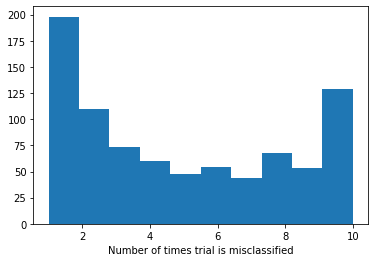

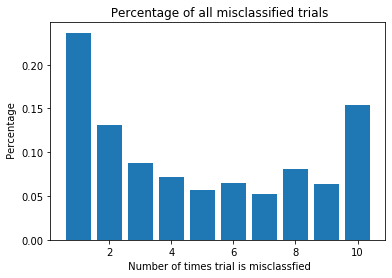

In [ ]:
name_1 = '/content/drive/My Drive/Processed data/10_cnn_hist.png'
name_2 = '/content/drive/My Drive/Processed data/10_cnn_percent.png'

fig = plt.figure(1)
a  = plt.hist(count[:,1], number )
plt.xlabel('Number of times trial is misclassified')
fig.savefig(name_1)

# Calculate percentages
percent = np.zeros(number)
for i in range (number):
  percent[i] = a[0][i]/len(uni)

fig = plt.figure(2)
plt.bar([1,2,3,4,5,6,7,8,9,10], percent)
plt.title(' Percentage of all misclassified trials')
plt.xlabel(' Number of times trial is misclassfied')
plt.ylabel(' Percentage')
fig.savefig(name_2)

()

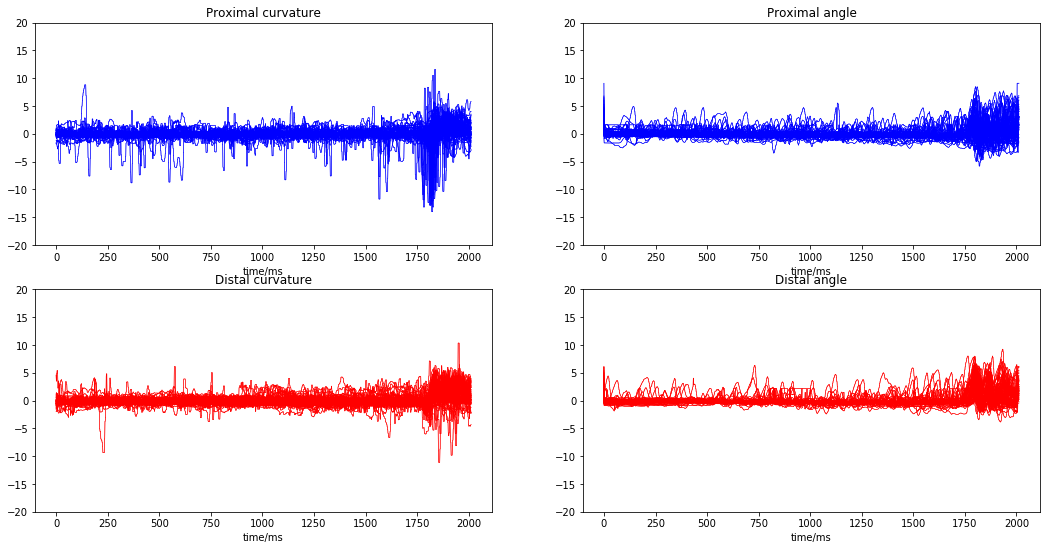

In [ ]:
# Plot 10 times wrongly classified trials and maybe once wrongly classifed too?

# find trials numbers that were 10 times wrongly classified

trials_10 = np.where(count[:,1] == 10 )

x_all = np.concatenate((xtrain, xtest))
y_all = np.concatenate((ytrain, ytest))
x_all_angle = np.concatenate((x_t_a, x_test_a))
x_all_curve = np.concatenate((x_t_c, x_test_c))

plot_some(x_all_curve[trials_10], x_all_angle[trials_10], y_all[trials_10], number, 0, 0, 0 )